In [1]:
# import libraries
import warnings
import numpy as np

import time
import matplotlib.pyplot as plt

# Let's do a relative import
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath('../src/*/'))
# print(SCRIPT_DIR)a
sys.path.append(os.path.dirname(SCRIPT_DIR))
from src.agent_chatGPT import DQNAgent
from src.environment import CabDriver


np.set_printoptions(threshold=sys.maxsize)
warnings.filterwarnings("ignore")


#### Load the time matrix and reformat to sparse representation

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("../Data/Inputs/TM.npy")
print(Time_matrix.shape)
print(Time_matrix[3][4][17][5])
# Example: (Returns Time Taken in H) 𝑇𝑖𝑚𝑒−𝑚𝑎𝑡𝑟𝑖𝑥[𝑠𝑡𝑎𝑟𝑡−𝑙𝑜𝑐][𝑒𝑛𝑑−𝑙𝑜𝑐][ℎ𝑜𝑢𝑟−𝑜𝑓−𝑡ℎ𝑒−𝑑𝑎𝑦] [𝑑𝑎𝑦−𝑜𝑓−𝑡ℎ𝑒−𝑤𝑒𝑒𝑘]


(5, 5, 24, 7)
6.0


In [3]:
# Understanding the min and max time duration of trips from one point to another

print("Minimimum time taken:", Time_matrix.min())
print("Maximum time taken:", Time_matrix.max())
print("Average time taken:", Time_matrix.mean())


Minimimum time taken: 0.0
Maximum time taken: 11.0
Average time taken: 3.0542857142857143


The maximum time taken is 11 hours. 

So, it is safe to say that the maximum time taken by the cab driver to move from one point to another is less than 1 day.

Difference compared to reference solution

The random_state_init now returns tuples in the code skeleton it was a list

In [6]:
# Check Random State
print("Random State Initialization:")
for i in range(5):  # Checking for 5 episodes
    env = CabDriver()
    random_state_init = env.state_init
    print(random_state_init)


Random State Initialization:
[3, 8, 6]
[0, 9, 3]
[1, 6, 6]
[2, 13, 1]
[0, 4, 4]


In [7]:
# Creating tuples of action_index and actions from action_space
env = CabDriver()
cab_action_space = env.action_space
cab_action_indices = [i for i in range(len(cab_action_space))]
action_list = [
    i for i in zip(cab_action_indices, cab_action_space)
]  # tuples (action_indices, action)
print("Action List (action_indices, action):")
action_list


Action List (action_indices, action):


[(0, [0, 0]),
 (1, [0, 0]),
 (2, [0, 1]),
 (3, [0, 2]),
 (4, [0, 3]),
 (5, [0, 4]),
 (6, [1, 0]),
 (7, [1, 2]),
 (8, [1, 3]),
 (9, [1, 4]),
 (10, [2, 0]),
 (11, [2, 1]),
 (12, [2, 3]),
 (13, [2, 4]),
 (14, [3, 0]),
 (15, [3, 1]),
 (16, [3, 2]),
 (17, [3, 4]),
 (18, [4, 0]),
 (19, [4, 1]),
 (20, [4, 2]),
 (21, [4, 3])]

In [8]:
# Understanding action_size
action_size = len(env.action_space)
print("action_size:", action_size)


action_size: 22


#### Tracking the state-action pairs for checking convergence
Using tuple unpacking to directly assign the state and action variables in the for loop

Using more descriptive variable names to make the code more readable and understandable

In [9]:
import collections
states_track = collections.defaultdict(dict)


def initialise_tracking_states():
    sample_q_values = [
        ((3, 0, 2), (3, 1)),
        ((1, 6, 3), (2, 3)),
        ((2, 2, 2), (3, 2)),
        ((3, 10, 6), (3, 4)),
        ((0, 20, 3), (1, 4)),
        ((1, 23, 3), (1, 4)),
    ]
    for state, action in sample_q_values:
        states_track[state][action] = []


# initialised all the state-action pairs tracked
initialise_tracking_states()


The states are being encoded multiple times in the original code snippet, leading to unnecessary computation and inefficiency. This has been fixed by encoding all the states once before making the predictions.

Using zip function to pair states and their corresponding predictions and extract them in the loop.

Avoiding the use of indexing by using the list.index() method which is an O(n) operation and using list comprehension to avoid multiple reshaping of state_encod

In [10]:
def save_tracking_states():
    state_encod = np.array([agent.convert_state_to_vector(state)
                           for state in states_track.keys()])
    state_encod = np.reshape(state_encod, [-1, agent.state_size])
    predictions = agent.model.predict(state_encod, verbose=0)

    for (state, actions), prediction in zip(states_track.items(), predictions):
        for action in actions:
            action_index = env.action_space.index(list(action))
            Q = prediction[action_index]
            states_track[state][action].append(Q)


In [11]:
import pickle
# Defining a function to save the Q-dictionary as a pickle file


def save_obj(obj, name):
    with open(name + ".pkl", "wb") as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


# Agent class initialization

### DQN Block

In [12]:
episode_time = 24 * 30  # 24 hrs for 30 days per episode
Episodes = 1  # No. of Episodes
m = 5  # No. Locations
t = 24  # No. of hrs in a day
d = 7  # No. of days in a week

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m + t + d
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

# to store rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state
rewards_init_state = []


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-01-18 13:00:44.097603: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-18 13:00:44.097763: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Training loop

In [15]:
start_time = time.time()
# tracking average reward per episode = total rewards in an episode/ total steps in an episode
avg_reward = []
# tracking total rewards per episode
total_reward = []
terminal_state = False
env = CabDriver()
for episode in range(0, Episodes):

    # tracking total rewards, step count
    tot_reward = 0
    step_count = 0
    terminal_state = False
    total_time = 0  # Total time driver rode in this episode

    # Reset at the start of each episode
    action_space, state_space, state = env.reset()
    # State initialization
    initial_state = state

    while not terminal_state:
        # 1. Pick epsilon-greedy action from possible actions for the current state.
        """
        The state needs first to be vectorized with env.convert_state_to_vector() before passing it to the DQN Agent get_action method. 
        Also the environment itself does not use the function internally but the Agent class needs it during prediction.
        That's why I commented it out from the env and transferred it to the agent class. It was defined in the code skeleton in the environment class.
        We'll see later if it's more optimal to have it in the environment once we start pruning and optimizing the code further.
        """
        # state_vec = agent.convert_state_to_vector(state)
        possible_actions_index, actions = env.requests(state)
        action = agent.get_action(state, possible_actions_index, episode)
        if agent.epsilon > agent.epsilon_min:
            agent.epsilon = agent.inverse_time_decay(1.0, agent.epsilon_decay, step_count)
        # 2. Evaluate your reward and next state
        """
        There is no env.step() function, the chatGPT did not formulate this. BUT
        it formulated functions that are needed to "take a step" or "replay" a situtation from the environment.
        next_state_func returns the next_stae tuple (dropoff, hour, day) and reward_func returns the reward.
        In addition to this we need to calculate the time 
        I added the step function to the environment class.
        NOTE: reward function and next state function are doing essentially the same lookup from the Time_matrix.
        In the next part of the series this is something that should be optimized f.ex. by merging them into get_next_state_and_reward_func()
        """
        next_state, reward, step_time = env.step(
            state, env.action_space[action], Time_matrix
        )
        # 3. Total time driver rode in this episode
        total_time += step_time
        if total_time > episode_time:
            # The cab driver accepts the last ride prior to the end of total time limit (720 hours).
            # So the last trip begins before the end of 720 hrs but the total time of episode might cross 720 hrs.
            terminal_state = True
        else:
            # 4. Append the experience to the memory
            agent.append_sample(state, action, reward,
                                next_state, terminal_state)
            # Note: Here action is action index
            # 5. Train the model by calling function agent.train_model
            agent.train_model()
            # 6. Update current state
            state = next_state
            tot_reward += reward
            step_count += 1

        # Epsilon-decay
        agent.epsilon = inverse_time_decay(
            agent.epsilon, agent.epsilon_decay, episode)

        # 7. Keep a track of rewards, Q-values, loss, etc.
        # (Note: Loss were tracking is the model loss='mse')
        if terminal_state and episode % 25 == 0:
            avg_reward.append(tot_reward / step_count)
            total_reward.append(tot_reward)
            print(
                "episode:",
                episode,
                "  score:",
                tot_reward,
                "  memory length:",
                len(agent.memory),
                "  epsilon:",
                agent.epsilon,
            )

    # Store 'agent_model' every 200th episode
    if episode % 200 == 0:
        agent.save(f"../Data/Outputs/chatGPT_dev/cab_driver.h5")

    # Every 25th episode
    if episode % 25 == 0:
        save_obj(avg_reward, "../Data/Outputs/chatGPT_dev/Rewards")
        save_tracking_states()
        save_obj(states_track, "../Data/Outputs/chatGPT_dev/States_tracked")
    # Every 10000th episodes
    if episode % 10000 == 0 and episode != 0:
        plt.plot(list(range(len(avg_reward))), avg_reward)
        plt.show()
    # Saving the 'DQN_model' and 'model_weights' every 1000th episode.
    if episode % 1000 == 0:
        print("Saving Model {}".format(episode))
        # Saves DQN model in Keras H5 format
        agent.save(name="../Data/Outputs/chatGPT_dev/DQN_model.h5")
        print("Saving Model {} Weights".format(episode))
        agent.save_weights_numpy(
            name="../Data/Outputs/chatGPT_dev/model_weights.pkl"
        )  # Saves model_weights in pkl file
        # (model_weights pickle file has a list of numpy arrays)

elapsed_time = time.time() - start_time
print(f"Elapsed time in sec: {elapsed_time}")


2023-01-18 13:00:44.660034: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-18 13:00:44.697969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-18 13:00:45.039196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


episode: 0   score: 2824.0   memory length: 141   epsilon: 1.0141999999999984
Saving Model 0
Saving Model 0 Weights
Elapsed time in sec: 11.112578868865967


2023-01-18 13:00:55.694834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


### Plot training results

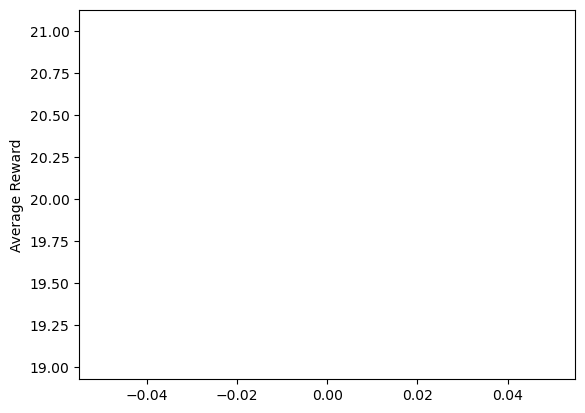

In [16]:
# Plotting average rewards
# x-values = 40000 episodes tracked after every 25th episode
plt.plot(list(range(len(avg_reward))), avg_reward)
plt.ylabel("Average Reward")
plt.show()


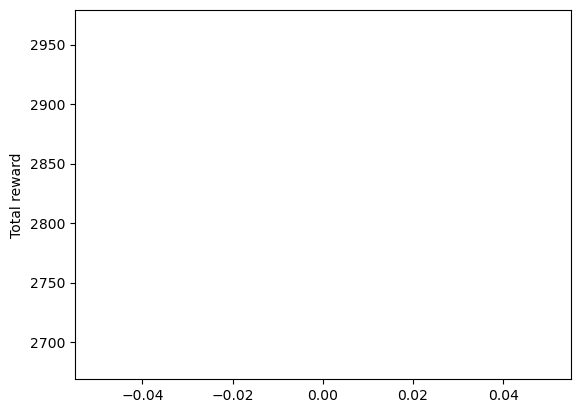

In [17]:
# Plotting total rewards
plt.plot(list(range(len(total_reward))), total_reward)
plt.ylabel("Total reward")
plt.show()


### Track convergence

ValueError: num must be 1 <= num <= 8, not 9

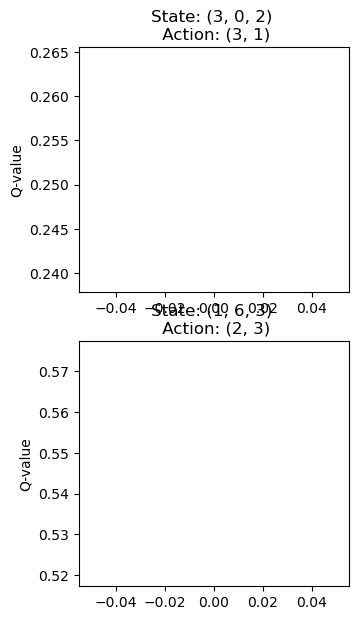

In [18]:
plt.figure(figsize=(16, 7))

# loop over all the states in states_track dictionary
for i, (state, actions) in enumerate(states_track.items()):
    # loop over all the actions of each state
    for j, (action, q_values) in enumerate(actions.items()):
        plt.subplot(2, 4, i*4 + j + 1)
        xaxis = np.asarray(range(len(q_values)))
        plt.plot(xaxis, np.asarray(q_values))
        plt.ylabel("Q-value")
        plt.title(f"State: {state} \n Action: {action}")

plt.show()


In [ ]:
plt.figure(figsize=(16, 7))

states_to_plot = [(3, 0, 2), (1, 6, 3), (2, 2, 2), (3, 10, 6), (0, 20, 3)]

for i, state in enumerate(states_to_plot):
    xaxis = np.asarray(range(500))
    plt.subplot(2, 5, i+1)
    plt.plot(xaxis, np.asarray(states_track[state][(3, 1)])[-500:])
    plt.ylabel("Q-value")

plt.show()
